localisation
- LN and WTE no longer be localised, because:
    - goal: where is domain knowledge stored?
    - LN: normalisaiton 목적이지 domain knowledge가 저장돼있다고 보기는 힘듦
    - WTE: word는 domain과 직접적인 연관을 갖고 있음
- model_editing(e.g. partial fine-tuning): LN, WTE는 반드시 tuned
- compression(e.g. pruning): LN, WTE는 대상에서 제외

- component unit: submodule, module

# Import libraries

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import argparse
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
from os import listdir
import json
import math
import seaborn as sns

/Users/joon/opt/anaconda3/envs/m2d2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
device_id = "cpu"
cache_dir = "/Users/joon/.cache/huggingface"

# n_params per submodule and module

In [3]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to(device_id)   # TODO

dict_n_module_params = {}

for base_tup in list(base_model.named_parameters()):
    dict_n_module_params[base_tup[0]]= base_tup[1].numel()

with open('./data/dict_n_module_params_230627.json', 'w') as json_file:
    json.dump(dict_n_module_params, json_file) 

def parse_code_module(row):
    list_code = row.code.split(".")
    is_in_layer = row["code"].startswith("transformer.h")
    if is_in_layer:        
        row["l"] = int(list_code[2])
        row["m"] = list_code[3]
    else:
        row["m"] = list_code[1]
        if row["m"] == "ln_f": 
            row["l"] = int(99)
        elif row["m"] in ["wte", "wpe"]: 
            row['l'] = int(-1)
    row["w_or_b"] = list_code[-1]
    row["is_in_layer"] = is_in_layer
    if row["m"] in ["attn", "mlp"]:
        row["s"] = list_code[-2]
    else:
        row["s"] = row["m"]
    
    return row

df_n_module_params = pd.DataFrame.from_dict(dict_n_module_params, orient='index').reset_index()
df_n_module_params.columns = ['code', 'n_params']
df_n_module_params = df_n_module_params.apply(lambda row: parse_code_module(row), axis=1)

is_localised = (df_n_module_params.m.isin(["attn", "mlp"])) & (df_n_module_params["is_in_layer"])
df_n_module_params["is_localised"] = is_localised

# df_n_module_params

In [4]:
df_n_submodule_params_agg = df_n_module_params\
    .loc[:, ["m", "s", "n_params", "w_or_b", "is_localised"]]\
    .groupby(["is_localised", "m", "s", "w_or_b"])\
    .agg({"n_params": ["count", "first", ]}).unstack(-1)\
    .fillna(0).astype(int).drop(("n_params", "count", "bias"), axis=1)

df_n_submodule_params_agg

n_params                
                            count first          
w_or_b                     weight  bias    weight
is_localised m    s                              
False        ln_1 ln_1         12   768       768
             ln_2 ln_2         12   768       768
             ln_f ln_f          1   768       768
             wpe  wpe           1     0    786432
             wte  wte           1     0  38597376
True         attn c_attn       12  2304   1769472
                  c_proj       12   768    589824
             mlp  c_fc         12  3072   2359296
                  c_proj       12   768   2359296

In [5]:
df_sub_cnt = df_n_submodule_params_agg\
    .drop(("n_params", "count", "weight"), axis=1)
# , ("n_params", "count", "weight")

- LayerNorm은 파라미터 수가 너무 적고, 역할을 생각해 볼 때 도메인 정보를 저장하고 있다고 보기는 힘듦


# Module

In [6]:
df_module_cnt = df_n_module_params.reset_index()\
    .loc[:, ["m", "s", "n_params", "w_or_b", "is_localised"]]\
    .drop_duplicates()\
    .groupby(["is_localised", "m", "w_or_b"])[["n_params"]].sum().unstack(-1)\
    .fillna(0).astype(int)

df_module_cnt = df_module_cnt.reset_index().drop("is_localised", axis=1)
df_module_cnt.columns = ["module", "bias", "weight"]
df_module_cnt["total"] = df_module_cnt["bias"] + df_module_cnt["weight"] 

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/2599073285.py:7: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_module_cnt = df_module_cnt.reset_index().drop("is_localised", axis=1)


## IN vs. ALL Rank Comparision

In [7]:
df_mod_diff_weights = pd.read_pickle("./data/df_avg_diff_weights_mod_230627.pkl")   # TODO

In [8]:

df_modules = df_mod_diff_weights\
    .groupby(["is_in_layer", "is_localised", "layer",  "component_id", "module"])[["diff", "scaled_diff"]].mean().reset_index()\
    .merge(df_module_cnt, on=["module"], how='left')


df_modules.loc[:, "v1_rank"] = df_modules["scaled_diff"].rank(ascending=False)

df_modules.loc[df_modules.is_localised, "v2_rank"]\
    = df_modules.loc[df_modules.is_localised]["scaled_diff"].rank(ascending=False)
df_modules["v2_rank"] = df_modules["v2_rank"].fillna(-1).astype(int)


n_mods = len(df_modules)
df_modules['v1_threshold'] = 100
for threshold in np.arange(0.8, -0.01, -0.2):
    df_modules.loc[df_modules["v1_rank"] < threshold * n_mods, 'v1_threshold'] = int(threshold * 100)


n_localised_mods = len(df_modules.loc[df_modules["is_localised"]])
df_modules['v2_threshold'] = 100
for threshold in np.arange(0.8, -0.01, -0.2):
    df_modules.loc[df_modules["v2_rank"] < threshold*n_localised_mods, 'v2_threshold'] = int(threshold * 100)
    


In [9]:
df_mod_in_rank = df_mod_diff_weights[:]

df_mod_in_rank.loc[:, "v1_in_rank"] \
    = df_mod_in_rank.groupby(["dataset"])["diff"].rank(ascending=False)

df_mod_in_rank.loc[df_mod_in_rank.is_localised, "v2_in_rank"] \
    = df_mod_in_rank.loc[df_mod_in_rank.is_localised].groupby(["dataset"])["diff"].rank(ascending=False)
df_mod_in_rank["v2_in_rank"] = df_mod_in_rank["v2_in_rank"].fillna(-1).astype(int)

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/2017858532.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod_in_rank.loc[:, "v1_in_rank"] \
/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/2017858532.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mod_in_rank.loc[df_mod_in_rank.is_localised, "v2_in_rank"] \
/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/2017858532.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slic

### v1: all modules
- in_rank = rank on inidividual difference per model
- all_rank = rank on scaled difference

In [10]:
df_v1 = df_mod_in_rank.groupby(["layer", "component_id"])\
    .agg({"v1_in_rank": ["mean", "std"]})#.rename({"mean":"v2_in_rank_mean", "std":"v2_in_rank_std"}, axis=1)
df_v1.columns = ["v1_in_rank_mean", "v1_in_rank_std"]

df_modules.loc[:, ["layer", "component_id", "v1_threshold", "v1_rank"]].sort_values('v1_rank')\
    .rename({"v1_rank": "v1_all_rank"}, axis=1)\
    .merge(df_v1.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1)

,component_id,v1_threshold,v1_all_rank,v1_in_rank_mean,v1_in_rank_std
0,h.11.ln_2,20,1.0,2.25,4.011497
1,h.0.ln_1,20,2.0,2.90,1.832456
2,ln_f,20,3.0,4.00,2.790963
3,h.11.mlp,20,4.0,8.45,6.492708
4,h.0.ln_2,20,5.0,10.05,6.589266
5,h.8.ln_1,20,6.0,14.45,12.318044
6,h.7.ln_1,20,7.0,15.85,15.065733
7,h.10.mlp,20,8.0,10.95,6.870800
8,h.9.ln_1,20,9.0,18.80,14.884114
9,h.10.ln_1,20,10.0,19.70,14.086574


In [24]:
df_mod_in_rank[["component_id", "v1_in_rank"]].merge(df_modules[["component_id", "v1_rank"]], on="component_id")[["v1_in_rank", "v1_rank"]].corr()

,v1_in_rank,v1_rank
v1_in_rank,1.000000,0.758552
v1_rank,0.758552,1.000000


### v2: modules except for LN, WTE

In [11]:
df_v2 = df_mod_in_rank.loc[df_mod_in_rank.is_localised].groupby(["layer", "component_id"])\
    .agg({"v2_in_rank": ["mean", "std"]}).rename({"mean":"v2_in_rank_mean", "std":"v2_in_rank_std"}, axis=1)
df_v2.columns = ["v2_in_rank_mean", "v2_in_rank_std"]

df_modules.loc[df_modules.is_localised, ["layer", "component_id", "v2_threshold", "v2_rank"]].sort_values('v2_rank')\
    .rename({"v2_rank": "v2_all_rank"}, axis=1)\
    .merge(df_v2.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1)

,component_id,v2_threshold,v2_all_rank,v2_in_rank_mean,v2_in_rank_std
0,h.11.mlp,20,1,1.00,0.000000
1,h.10.mlp,20,2,2.00,0.000000
2,h.9.mlp,20,3,3.20,0.410391
3,h.0.attn,20,4,4.45,2.564433
4,h.11.attn,40,5,4.95,0.223607
5,h.8.mlp,40,6,5.90,0.447214
6,h.10.attn,40,7,6.90,0.447214
7,h.9.attn,40,8,8.05,0.223607
8,h.8.attn,40,9,9.20,0.410391
9,h.7.mlp,60,10,10.00,1.076055


In [19]:
df_v2 = df_mod_in_rank.loc[df_mod_in_rank.is_localised].groupby(["layer", "component_id"])\
    .agg({"v2_in_rank": ["mean", "std"]}).rename({"mean":"v2_in_rank_mean", "std":"v2_in_rank_std"}, axis=1)
df_v2.columns = ["v2_in_rank_mean", "v2_in_rank_std"]

df_modules.loc[df_modules.is_localised, ["layer", "component_id", "v2_threshold", "v2_rank"]].sort_values('v2_rank')\
    .rename({"v2_rank": "v2_all_rank"}, axis=1)\
    .merge(df_v2.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1)[["v2_in_rank_mean", "v2_all_rank"]].corr()

,v2_in_rank_mean,v2_all_rank
v2_in_rank_mean,1.000000,0.996157
v2_all_rank,0.996157,1.000000


In [12]:
n_total_params = sum(p.numel() for p in base_model.parameters())
df_modules.total.sum(), n_total_params, df_modules.total.sum() == n_total_params

(124439808, 124439808, True)

## modules by threshold

### v1: all modules

In [13]:
df_modules_agg = df_modules.groupby(["v1_threshold"]).agg({
    "component_id": [list],
    "total": ["count", "sum"],
})

df_modules_agg.columns = ["component_ids", "mod_cnt", "params"]
df_modules_agg["accum_params"] = df_modules_agg["params"].cumsum()
df_modules_agg["accum_prop_params"] = df_modules_agg["accum_params"] / n_total_params
df_modules_agg["component_ids"] = df_modules_agg["component_ids"].apply(lambda l: ", ".join(l))

In [14]:
df_modules_agg

,component_ids,mod_cnt,params,accum_params,accum_prop_params
v1_threshold,,,,,
20,"ln_f, h.0.ln_1, h.0.ln_2, h.7.ln_1, h.8.ln_1, ...",10,9457152,9457152,0.075998
40,"wte, h.3.ln_1, h.5.ln_1, h.6.ln_1, h.0.attn, h...",10,57496320,66953472,0.538039
60,"h.2.ln_1, h.4.ln_1, h.5.ln_2, h.3.attn, h.4.at...",10,21261312,88214784,0.708895
80,"h.6.ln_2, h.7.ln_2, h.11.ln_1, h.1.attn, h.2.a...",10,25981440,114196224,0.917682
100,"wpe, h.1.ln_1, h.1.ln_2, h.2.ln_2, h.3.ln_2, h...",11,10243584,124439808,1.000000


### v2: modules except for LN, WTE

In [15]:
df_modules_agg = df_modules.groupby(["v2_threshold"]).agg({
    "component_id": [list],
    "total": ["count", "sum"],
})

df_modules_agg.columns = ["component_ids", "mod_cnt", "params"]
df_modules_agg["accum_params"] = df_modules_agg["params"].cumsum()
df_modules_agg["accum_prop_params"] = df_modules_agg["accum_params"] / n_total_params
df_modules_agg["component_ids"] = df_modules_agg["component_ids"].apply(lambda l: ", ".join(l))

In [16]:
df_modules_agg

,component_ids,mod_cnt,params,accum_params,accum_prop_params
v2_threshold,,,,,
0,"wpe, wte, ln_f, h.0.ln_1, h.0.ln_2, h.1.ln_1, ...",27,39422208,39422208,0.316797
20,"h.0.attn, h.9.mlp, h.10.mlp, h.11.mlp",4,16529664,55951872,0.449630
40,"h.8.attn, h.8.mlp, h.9.attn, h.10.attn, h.11.attn",5,14171904,70123776,0.563516
60,"h.4.attn, h.6.attn, h.6.mlp, h.7.attn, h.7.mlp",5,16531968,86655744,0.696367
80,"h.2.attn, h.3.attn, h.4.mlp, h.5.attn, h.5.mlp",5,16531968,103187712,0.829218
100,"h.0.mlp, h.1.attn, h.1.mlp, h.2.mlp, h.3.mlp",5,21252096,124439808,1.000000


## correlation between rankings

### v1: all modules

In [24]:
df_mod_in_rank[["component_id", "v1_in_rank"]].merge(df_modules[["component_id", "v1_rank"]], on="component_id")[["v1_in_rank", "v1_rank"]].corr()

,v1_in_rank,v1_rank
v1_in_rank,1.000000,0.758552
v1_rank,0.758552,1.000000


### v2: modules except for LN, WTE

In [26]:
df_mod_in_rank[["component_id", "v2_in_rank"]].merge(df_modules[["component_id", "v2_rank"]], on="component_id")[["v2_in_rank", "v2_rank"]].corr()

,v2_in_rank,v2_rank
v2_in_rank,1.000000,0.994994
v2_rank,0.994994,1.000000


In [27]:
l_temp = [39422208,
16529664,
14171904,
16531968,
16531968,
21252096]

[val / sum(l_temp) for val in l_temp]

[0.3167974029660991,
 0.13283260610623893,
 0.11388561448117952,
 0.1328511210817683,
 0.1328511210817683,
 0.17078213428294586]

## heatmap

### v1

In [292]:
list_layer_module_v1 = []
for layer in range(0, 12):
    for c in ["ln_1", "attn", "ln_2", "mlp"]:
        list_layer_module_v1.append(f"{layer}-{c}")

list_layer_module_v1 = ["-1-wte", "-1-wpe"] + list_layer_module_v1 + ["99-ln_f"]

#### all

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/3551704644.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["layer_module"] = df_temp["layer"].astype(str) + "-" + df_temp["module"]


<Axes: xlabel='layer_module'>

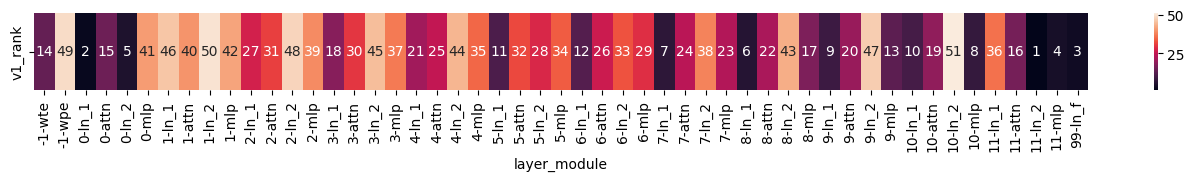

In [434]:
df_temp = df_modules[["module", "layer", "v1_rank"]]
df_temp["layer_module"] = df_temp["layer"].astype(str) + "-" + df_temp["module"]
plt.rcParams["figure.figsize"] = (17,1)
df_temp = df_temp.drop(["layer", "module"], axis=1).set_index("layer_module").loc[list_layer_module_v1].T
sns.heatmap(
    df_temp,
    annot=True
)


#### in

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/2187982464.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["layer_module"] = df_temp["layer"].astype(str) + "-" + df_temp["module"]


<Axes: xlabel='layer_module'>

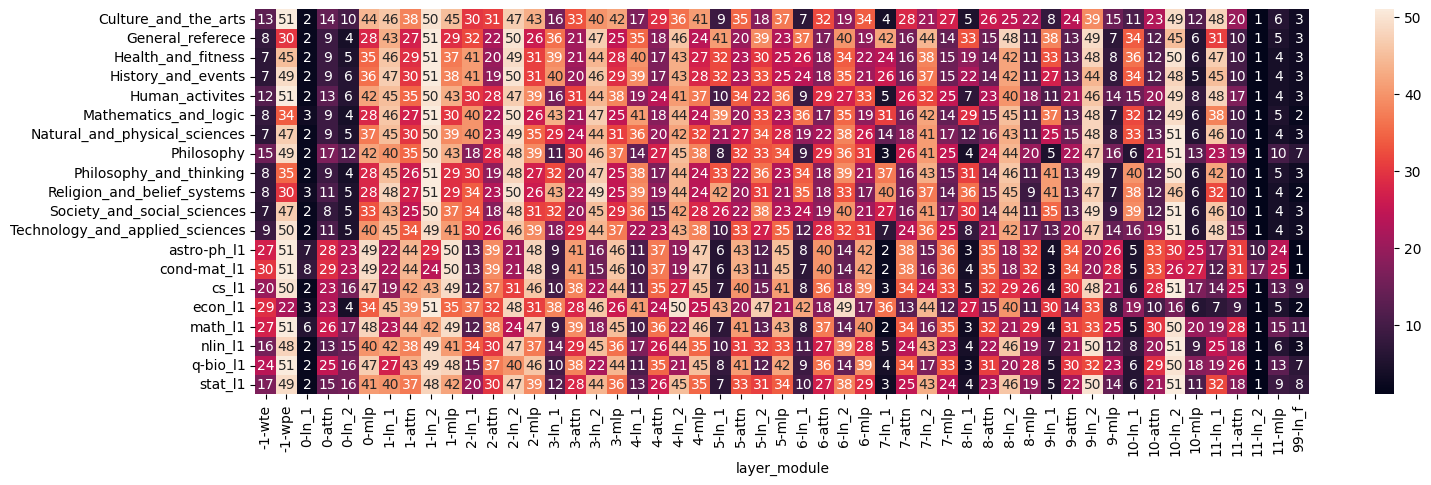

In [ ]:
# temp = df_temp.T.index.tolist()
df_temp = df_mod_in_rank[["dataset", "module", "layer", "v1_in_rank"]]
df_temp["layer_module"] = df_temp["layer"].astype(str) + "-" + df_temp["module"]
df_temp= df_temp.drop(["layer", "module"], axis=1)
df_temp= df_temp.set_index(["layer_module", "dataset"]).unstack(-1)
df_temp = df_temp.loc[list_layer_module_v1]
df_temp.columns = [tup[1] for tup in df_temp.columns]

plt.rcParams["figure.figsize"] = (17,5)
sns.heatmap(
    df_temp.T,
    annot=True
)


### v2

In [431]:
list_layer_module_v2 = []
for layer in range(0, 12):
    for c in ["attn", "mlp"]:
        list_layer_module_v2.append(f"{layer}-{c}")

list_layer_module_v2 =list_layer_module_v2

#### all

<Axes: xlabel='layer_module'>

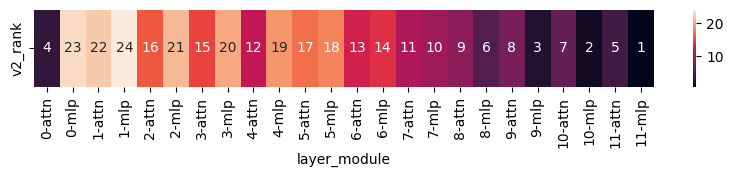

In [432]:
df_temp = df_modules.loc[df_modules.is_localised][["module", "layer", "v2_rank"]]
df_temp["layer_module"] = df_temp["layer"].astype(str) + "-" + df_temp["module"]
plt.rcParams["figure.figsize"] = (10,1)
df_temp = df_temp.drop(["layer", "module"], axis=1).set_index("layer_module").loc[list_layer_module_v2].T
sns.heatmap(
    df_temp,
    annot=True
)


#### in

<Axes: xlabel='layer_module'>

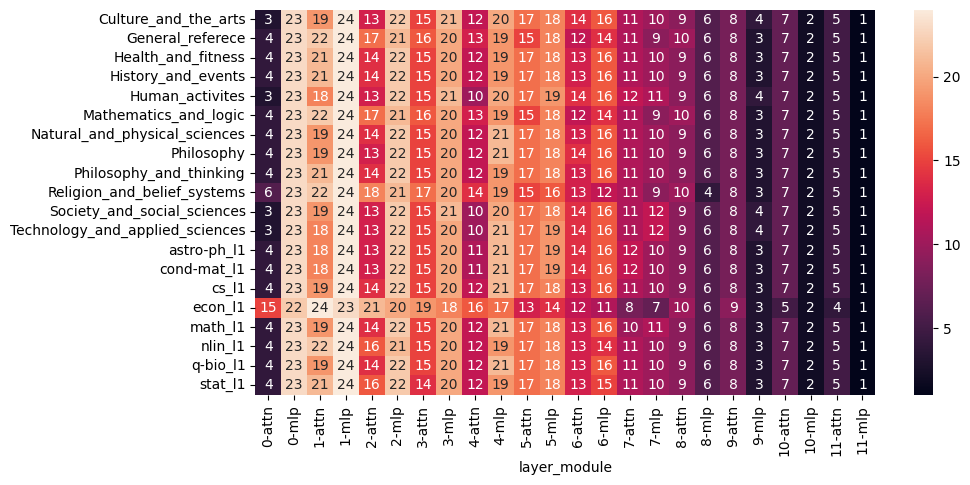

In [433]:
temp = df_temp.T.index.tolist()
df_temp = df_mod_in_rank.loc[df_mod_in_rank.is_localised, ["dataset", "module", "layer", "v2_in_rank"]]
df_temp["layer_module"] = df_temp["layer"].astype(str) + "-" + df_temp["module"]
df_temp= df_temp.sort_values(["layer", "module"]).drop(["layer", "module"], axis=1)
df_temp= df_temp.set_index(["layer_module", "dataset"]).unstack(-1)

df_temp = df_temp.loc[list_layer_module_v2, :]
df_temp.columns = [tup[1] for tup in df_temp.columns]

plt.rcParams["figure.figsize"] = (10,5)
sns.heatmap(
    df_temp.T,
    annot=True
)


# Submodule

In [29]:
df_sub_cnt = df_sub_cnt.reset_index().drop("is_localised", axis=1)
df_sub_cnt.columns = ["module", "submodule", "bias", "weight"]
df_sub_cnt["total"] = df_sub_cnt["bias"] + df_sub_cnt["weight"] 

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/2773299246.py:1: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df_sub_cnt = df_sub_cnt.reset_index().drop("is_localised", axis=1)


## IN vs. ALL Rank Comparision

In [384]:
df_sub_diff_weights = pd.read_pickle("./data/df_avg_diff_weights_sub_230627.pkl")

df_sub_diff_weights = df_sub_diff_weights.rename({"sub_module": "submodule"}, axis=1)
df_sub_diff_weights = df_sub_diff_weights.loc[df_sub_diff_weights.w_or_b == "weight"].drop(["w_or_b"], axis=1)
df_sub_diff_weights.submodule = df_sub_diff_weights.component_id.apply(lambda x: x.split(".")[-1])
is_in_layer = ~(df_sub_diff_weights.layer.isin([-1, 99]))
df_sub_diff_weights["is_in_layer"] = is_in_layer

is_localised = (df_sub_diff_weights.module.isin(["attn", "mlp"])) & is_in_layer
df_sub_diff_weights["is_localised"] =  is_localised

In [386]:
df_submodules = df_sub_diff_weights\
    .groupby(["is_localised", "layer",  "component_id", "module", "submodule"])[["diff", "scaled_diff"]].mean().reset_index()\
    .merge(df_sub_cnt, on=["module", "submodule"], how='left')
    # .groupby(["is_in_layer", "is_localised", "layer",  "component_id", "module"])[["diff", "scaled_diff"]].mean().reset_index()\

df_submodules.loc[:, "v1_rank"] = df_submodules["scaled_diff"].rank(ascending=False)

df_submodules.loc[df_submodules.is_localised, "v2_rank"]\
    = df_submodules.loc[df_submodules.is_localised]["scaled_diff"].rank(ascending=False)
df_submodules["v2_rank"] = df_submodules["v2_rank"].fillna(-1).astype(int)


n_subs = len(df_submodules)
df_submodules['v1_threshold'] = 100
for threshold in np.arange(0.8, -0.01, -0.2):
    df_submodules.loc[df_submodules["v1_rank"] < threshold * n_subs, 'v1_threshold'] = int(threshold * 100)


n_localised_subs = len(df_submodules.loc[df_submodules["is_localised"]])
df_submodules['v2_threshold'] = 100
for threshold in np.arange(0.8, -0.01, -0.2):
    df_submodules.loc[df_submodules["v2_rank"] < threshold*n_localised_subs, 'v2_threshold'] = int(threshold * 100)
    

df_sub_in_rank = df_sub_diff_weights[:]

df_sub_in_rank.loc[:, "v1_in_rank"] \
    = df_sub_in_rank.groupby(["dataset"])["diff"].rank(ascending=False)

df_sub_in_rank.loc[df_sub_in_rank.is_localised, "v2_in_rank"] \
    = df_sub_in_rank.loc[df_sub_in_rank.is_localised].groupby(["dataset"])["diff"].rank(ascending=False)
df_sub_in_rank["v2_in_rank"] = df_sub_in_rank["v2_in_rank"].fillna(-1).astype(int)

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/2039774386.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_in_rank.loc[:, "v1_in_rank"] \
/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/2039774386.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub_in_rank.loc[df_sub_in_rank.is_localised, "v2_in_rank"] \
/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/2039774386.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

### v1: all modules
- in_rank = rank on inidividual difference per model
- all_rank = rank on scaled difference

In [387]:
df_v1 = df_sub_in_rank.groupby(["layer", "component_id"])\
    .agg({"v1_in_rank": ["mean", "std"]})#.rename({"mean":"v2_in_rank_mean", "std":"v2_in_rank_std"}, axis=1)
df_v1.columns = ["v1_in_rank_mean", "v1_in_rank_std"]

df_submodules.loc[:, ["layer", "component_id", "v1_threshold", "v1_rank"]].sort_values('v1_rank')\
    .rename({"v1_rank": "v1_all_rank"}, axis=1)\
    .merge(df_v1.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1)

,component_id,v1_threshold,v1_all_rank,v1_in_rank_mean,v1_in_rank_std
0,h.11.ln_2,20,1.0,2.25,4.011497
1,h.0.ln_1,20,2.0,2.90,1.832456
2,ln_f,20,3.0,4.25,2.899637
3,h.11.mlp.c_proj,20,4.0,7.30,5.822823
4,h.10.mlp.c_proj,20,5.0,9.80,6.152449
...,...,...,...,...,...
70,h.1.mlp.c_proj,100,71.0,66.90,6.935037
71,h.2.ln_2,100,72.0,62.30,18.487834
72,wpe,100,73.0,67.80,10.714476
73,h.1.ln_2,100,74.0,67.70,14.157386


In [388]:
df_submodules.loc[:, ["layer", "component_id", "v1_threshold", "v1_rank"]].sort_values('v1_rank')\
    .rename({"v1_rank": "v1_all_rank"}, axis=1)\
    .merge(df_v1.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1).head(38)

,component_id,v1_threshold,v1_all_rank,v1_in_rank_mean,v1_in_rank_std
0,h.11.ln_2,20,1.0,2.25,4.011497
1,h.0.ln_1,20,2.0,2.90,1.832456
2,ln_f,20,3.0,4.25,2.899637
3,h.11.mlp.c_proj,20,4.0,7.30,5.822823
4,h.10.mlp.c_proj,20,5.0,9.80,6.152449
5,h.0.ln_2,20,6.0,11.70,7.079251
6,h.8.ln_1,20,7.0,22.70,21.701564
7,h.7.ln_1,20,8.0,24.70,25.116780
8,h.0.attn.c_attn,20,9.0,13.20,8.319919
9,h.9.ln_1,20,10.0,27.90,24.565487


In [389]:
df_submodules.loc[:, ["layer", "component_id", "v1_threshold", "v1_rank"]].sort_values('v1_rank')\
    .rename({"v1_rank": "v1_all_rank"}, axis=1)\
    .merge(df_v1.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1).tail(37)

,component_id,v1_threshold,v1_all_rank,v1_in_rank_mean,v1_in_rank_std
38,h.3.attn.c_attn,60,39.0,32.15,6.619548
39,h.2.mlp.c_fc,60,40.0,38.65,6.714282
40,h.0.mlp.c_fc,60,41.0,39.15,5.584518
41,h.6.attn.c_attn,60,42.0,41.70,8.285053
42,h.5.attn.c_attn,60,43.0,43.30,8.053113
43,h.7.attn.c_proj,60,44.0,43.60,12.347597
44,h.2.ln_1,60,45.0,41.00,19.144877
45,h.5.ln_2,80,46.0,40.30,19.043164
46,h.7.mlp.c_proj,80,47.0,45.25,8.729110
47,h.6.attn.c_proj,80,48.0,46.65,10.569445


### v2: modules except for LN, WTE

In [390]:
df_v2 = df_sub_in_rank.loc[df_sub_in_rank.is_localised].groupby(["layer", "component_id"])\
    .agg({"v2_in_rank": ["mean", "std"]})#.rename({"mean":"v2_in_rank_mean", "std":"v2_in_rank_std"}, axis=1)

df_v2.columns = ["v2_in_rank_mean", "v2_in_rank_std"]

# df_submodules.loc[df_submodules.is_localised, ["layer", "component_id", "v2_threshold", "v2_rank"]].sort_values('v2_rank')\
#     .rename({"v2_rank": "v2_all_rank"}, axis=1)\
#     .merge(df_v2.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1)

In [391]:
df_submodules.loc[df_submodules.is_localised, ["layer", "component_id", "v2_threshold", "v2_rank"]].sort_values('v2_rank')\
    .rename({"v2_rank": "v2_all_rank"}, axis=1)\
    .merge(df_v2.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1).head(24)

,component_id,v2_threshold,v2_all_rank,v2_in_rank_mean,v2_in_rank_std
0,h.11.mlp.c_proj,20,1,1.25,1.118034
1,h.10.mlp.c_proj,20,2,2.40,1.788854
2,h.0.attn.c_attn,20,3,4.65,5.441314
3,h.11.attn.c_proj,20,4,4.15,0.366348
4,h.11.mlp.c_fc,20,5,5.40,1.698296
5,h.9.mlp.c_proj,20,6,6.20,2.820974
6,h.10.attn.c_proj,20,7,6.40,1.142481
7,h.10.mlp.c_fc,20,8,7.55,1.538112
8,h.9.mlp.c_fc,20,9,9.30,1.341641
9,h.9.attn.c_proj,40,10,9.25,0.910465


In [392]:
df_submodules.loc[df_submodules.is_localised, ["layer", "component_id", "v2_threshold", "v2_rank"]].sort_values('v2_rank')\
    .rename({"v2_rank": "v2_all_rank"}, axis=1)\
    .merge(df_v2.reset_index(), on=["component_id", "layer"], how='left').drop("layer", axis=1).tail(24)

,component_id,v2_threshold,v2_all_rank,v2_in_rank_mean,v2_in_rank_std
24,h.2.attn.c_attn,60,25,18.90,7.919995
25,h.3.attn.c_attn,60,26,19.55,6.012925
26,h.2.mlp.c_fc,60,27,25.80,2.375312
27,h.0.mlp.c_fc,60,28,26.15,5.392734
28,h.6.attn.c_attn,80,29,28.65,0.812728
29,h.5.attn.c_attn,80,30,30.20,0.523148
30,h.7.attn.c_proj,80,31,30.35,5.833434
31,h.7.mlp.c_proj,80,32,31.95,1.731291
32,h.6.attn.c_proj,80,33,33.05,3.817894
33,h.1.mlp.c_fc,80,34,32.65,2.134306


In [393]:
df_modules.total.sum(), n_total_params, df_submodules.total.sum() == n_total_params

(124439808, 124439808, True)

## modules by threshold

### v1: all modules
- in_rank = rank on inidividual difference per model
- all_rank = rank on scaled difference

In [394]:

df_submodules_agg = df_submodules.groupby(["v1_threshold"]).agg({
    "component_id": [list],
    "total": ["count", "sum"],
})

df_submodules_agg.columns = ["component_ids", "mod_cnt", "params"]
df_submodules_agg["prop"] = df_submodules_agg["params"] / n_total_params
df_submodules_agg["accum_params"] = df_submodules_agg["params"].cumsum()
df_submodules_agg["accum_prop_params"] = df_submodules_agg["accum_params"] / n_total_params
df_submodules_agg["component_ids"] = df_submodules_agg["component_ids"].apply(lambda l: ", ".join(l))
df_submodules_agg

,component_ids,mod_cnt,params,prop,accum_params,accum_prop_params
v1_threshold,,,,,,
20,"h.0.ln_1, h.0.ln_2, h.5.ln_1, h.7.ln_1, h.8.ln...",15,11818752,0.094976,11818752,0.094976
40,"wte, h.3.ln_1, h.4.ln_1, h.6.ln_1, h.4.attn.c_...",15,59860992,0.481044,71679744,0.576019
60,"h.2.ln_1, h.0.mlp.c_fc, h.2.attn.c_attn, h.2.m...",15,24806400,0.199345,96486144,0.775364
80,"h.4.ln_2, h.5.ln_2, h.6.ln_2, h.7.ln_2, h.8.ln...",14,12995328,0.104431,109481472,0.879795
100,"wpe, h.1.ln_1, h.1.ln_2, h.2.ln_2, h.3.ln_2, h...",16,14958336,0.120205,124439808,1.000000


### v2: modules except for LN, WTE

In [413]:
df_submodules_agg = df_submodules.groupby(["v2_threshold"]).agg({
    "component_id": [list],
    "total": ["count", "sum"],
})

df_submodules_agg.columns = ["component_ids", "mod_cnt", "params"]
df_submodules_agg["prop"] = df_submodules_agg["params"] / n_total_params
df_submodules_agg["accum_params"] = df_submodules_agg["params"].cumsum()
df_submodules_agg["accum_prop_params"] = df_submodules_agg["accum_params"] / n_total_params
df_submodules_agg["component_ids"] = df_submodules_agg["component_ids"].apply(lambda l: ", ".join(l))
df_submodules_agg

,component_ids,mod_cnt,params,prop,accum_params,accum_prop_params
v2_threshold,,,,,,
0,"wpe, wte, h.0.ln_1, h.0.ln_2, h.1.ln_1, h.1.ln...",27,39422208,0.316797,39422208,0.316797
20,"h.0.attn.c_attn, h.9.mlp.c_fc, h.9.mlp.c_proj,...",9,17120256,0.137579,56542464,0.454376
40,"h.4.attn.c_attn, h.5.mlp.c_fc, h.6.mlp.c_fc, h...",10,18306048,0.147108,74848512,0.601484
60,"h.0.mlp.c_fc, h.2.attn.c_attn, h.2.mlp.c_fc, h...",9,18308352,0.147126,93156864,0.748610
80,"h.1.attn.c_attn, h.1.mlp.c_fc, h.4.attn.c_proj...",10,14760192,0.118613,107917056,0.867223
100,"h.0.attn.c_proj, h.0.mlp.c_proj, h.1.attn.c_pr...",10,16522752,0.132777,124439808,1.000000


## correlation between rankings

### v1: all modules

In [414]:
df_sub_in_rank[["component_id", "v1_in_rank"]].merge(df_submodules[["component_id", "v1_rank"]], on="component_id")[["v1_in_rank", "v1_rank"]].corr()

,v1_in_rank,v1_rank
v1_in_rank,1.000000,0.792516
v1_rank,0.792516,1.000000


### v2: modules except for LN, WTE

In [415]:
df_sub_in_rank[["component_id", "v2_in_rank"]].merge(df_submodules[["component_id", "v2_rank"]], on="component_id")[["v2_in_rank", "v2_rank"]].corr()

,v2_in_rank,v2_rank
v2_in_rank,1.000000,0.985781
v2_rank,0.985781,1.000000


## heatmap

### v1

In [437]:
list_layer_submodule_v1 = []
for layer in range(0, 12):
    for c in ["ln_1", "attn.c_attn", "attn.c_proj", "ln_2", "mlp.c_fc", "mlp.c_proj"]:
        list_layer_submodule_v1.append(f"{layer}.{c}")

list_layer_submodule_v1 = ["-1.wte", "-1.wpe"] + list_layer_submodule_v1 + ["99.ln_f"]

#### all

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/2260184876.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.loc[df_temp["module"] == df_temp["submodule"], "mod_sub"] = df_temp.loc[df_temp["module"] == df_temp["submodule"], "module"]
/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/2260184876.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["mod_sub"]=df_temp["mod_sub"].fillna(df_temp["module"] + "." + df_temp["submodule"])
/var/folders/_k/vry5m2bj1p7d9f

<Axes: xlabel='layer_submodule'>

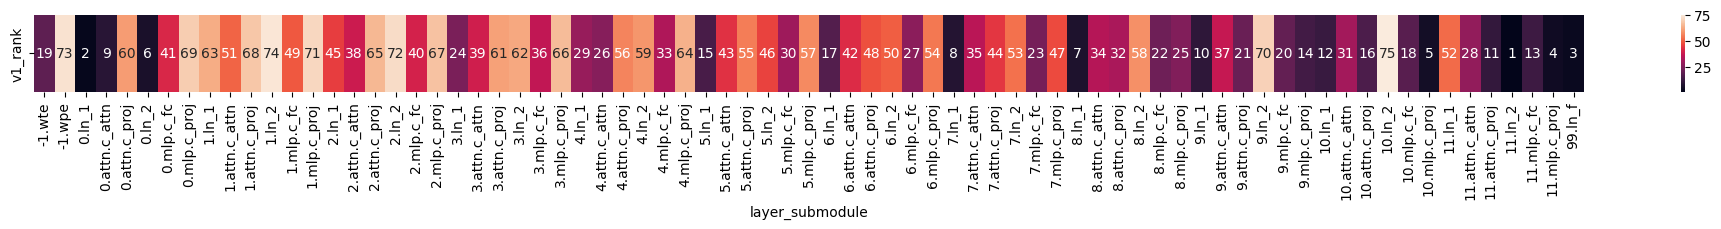

In [438]:
df_temp = df_submodules[["module", "submodule", "layer", "v1_rank"]]
df_temp.loc[df_temp["module"] == df_temp["submodule"], "mod_sub"] = df_temp.loc[df_temp["module"] == df_temp["submodule"], "module"]
df_temp["mod_sub"]=df_temp["mod_sub"].fillna(df_temp["module"] + "." + df_temp["submodule"])
df_temp["layer_submodule"] = df_temp["layer"].astype(str) + "." + df_temp["mod_sub"]

plt.rcParams["figure.figsize"] = (25,1)
df_temp = df_temp.drop(["layer", "mod_sub", "module", "submodule"], axis=1).set_index("layer_submodule").loc[list_layer_submodule_v1].T
sns.heatmap(
    df_temp,
    annot=True
)


#### in

/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/3276770328.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp.loc[df_temp["module"] == df_temp["submodule"], "mod_sub"] = df_temp.loc[df_temp["module"] == df_temp["submodule"], "module"]
/var/folders/_k/vry5m2bj1p7d9fy02j7_q0xh0000gn/T/ipykernel_15175/3276770328.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["mod_sub"]=df_temp["mod_sub"].fillna(df_temp["module"] + "." + df_temp["submodule"])
/var/folders/_k/vry5m2bj1p7d9f

<Axes: xlabel='layer_submodule'>

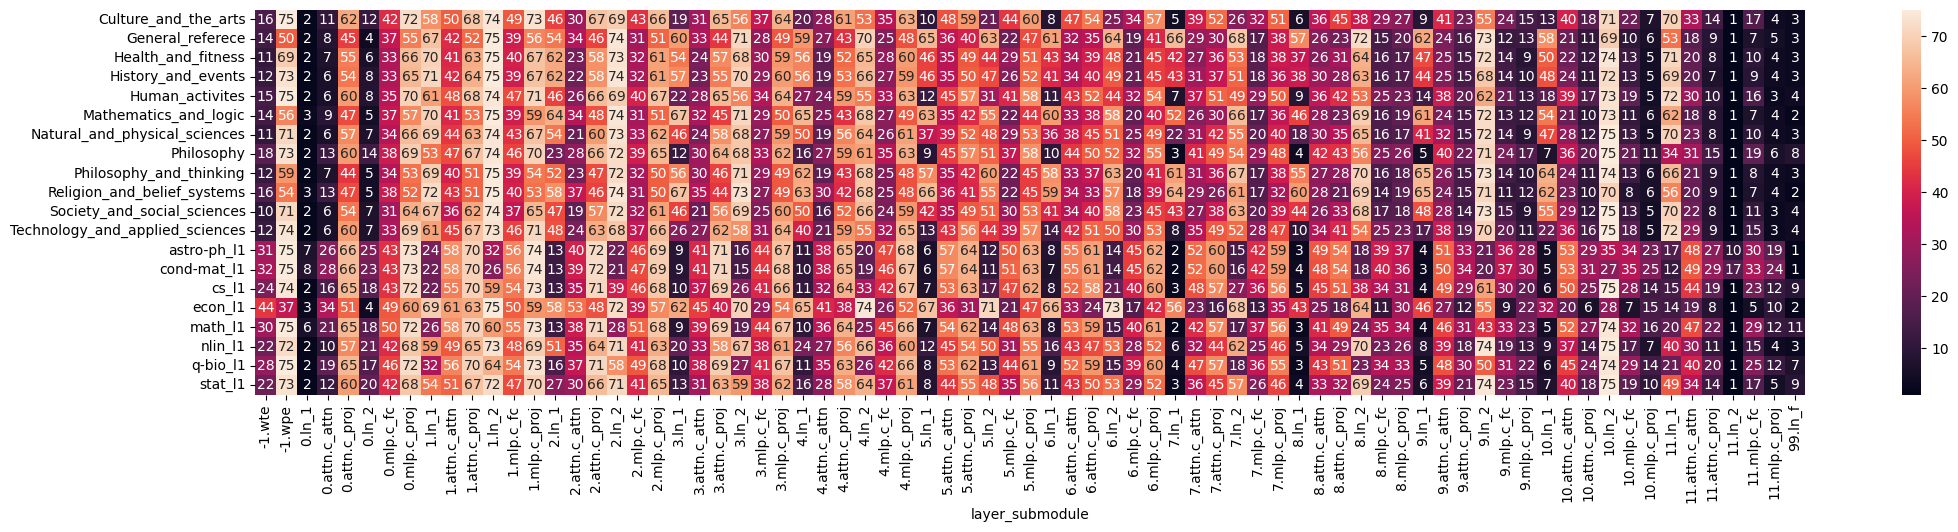

In [440]:
# temp = df_temp.T.index.tolist()
df_temp = df_sub_in_rank[["module", "submodule", "dataset", "layer", "v1_in_rank"]]
df_temp.loc[df_temp["module"] == df_temp["submodule"], "mod_sub"] = df_temp.loc[df_temp["module"] == df_temp["submodule"], "module"]
df_temp["mod_sub"]=df_temp["mod_sub"].fillna(df_temp["module"] + "." + df_temp["submodule"])
df_temp["layer_submodule"] = df_temp["layer"].astype(str) + "." + df_temp["mod_sub"]
df_temp = df_temp.drop(["layer", "mod_sub", "module", "submodule"], axis=1)
df_temp= df_temp.set_index(["layer_submodule", "dataset"]).unstack(-1).loc[list_layer_submodule_v1]
df_temp.columns = [tup[1] for tup in df_temp.columns]

plt.rcParams["figure.figsize"] = (25,5)
sns.heatmap(
    df_temp.T,
    annot=True
)


### v2

In [425]:
list_layer_submodule_v2 = []
for layer in range(0, 12):
    for c in ["attn.c_attn", "attn.c_proj", "mlp.c_fc", "mlp.c_proj"]:
        list_layer_submodule_v2.append(f"{layer}.{c}")

list_layer_submodule_v2 = list_layer_submodule_v2

#### all

<Axes: xlabel='layer_submodule'>

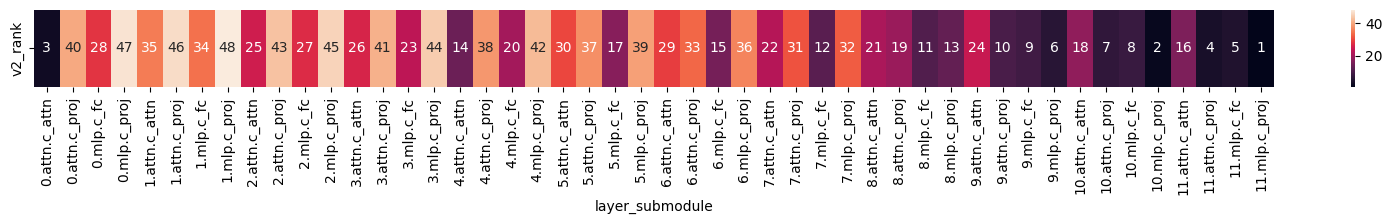

In [442]:
df_temp = df_submodules.loc[df_submodules.is_localised][["module", "submodule", "layer", "v2_rank"]]
df_temp.loc[df_temp["module"] == df_temp["submodule"], "mod_sub"] = df_temp.loc[df_temp["module"] == df_temp["submodule"], "module"]
df_temp["mod_sub"]=df_temp["mod_sub"].fillna(df_temp["module"] + "." + df_temp["submodule"])
df_temp["layer_submodule"] = df_temp["layer"].astype(str) + "." + df_temp["mod_sub"]

plt.rcParams["figure.figsize"] = (20,1)
df_temp = df_temp.drop(["layer", "mod_sub", "module", "submodule"], axis=1).set_index("layer_submodule").loc[list_layer_submodule_v2].T
sns.heatmap(
    df_temp,
    annot=True
)


#### in

In [443]:
# temp = df_temp.T.index.tolist()
df_temp = df_sub_in_rank.loc[df_sub_in_rank.is_localised][["module", "submodule", "dataset", "layer", "v2_in_rank"]]
df_temp.loc[df_temp["module"] == df_temp["submodule"], "mod_sub"] = df_temp.loc[df_temp["module"] == df_temp["submodule"], "module"]
df_temp["mod_sub"]=df_temp["mod_sub"].fillna(df_temp["module"] + "." + df_temp["submodule"])
df_temp["layer_submodule"] = df_temp["layer"].astype(str) + "." + df_temp["mod_sub"]
df_temp = df_temp.drop(["layer", "mod_sub", "module", "submodule"], axis=1)
df_temp= df_temp.set_index(["layer_submodule", "dataset"]).unstack(-1).loc[list_layer_submodule_v2]



<Axes: xlabel='layer_submodule'>

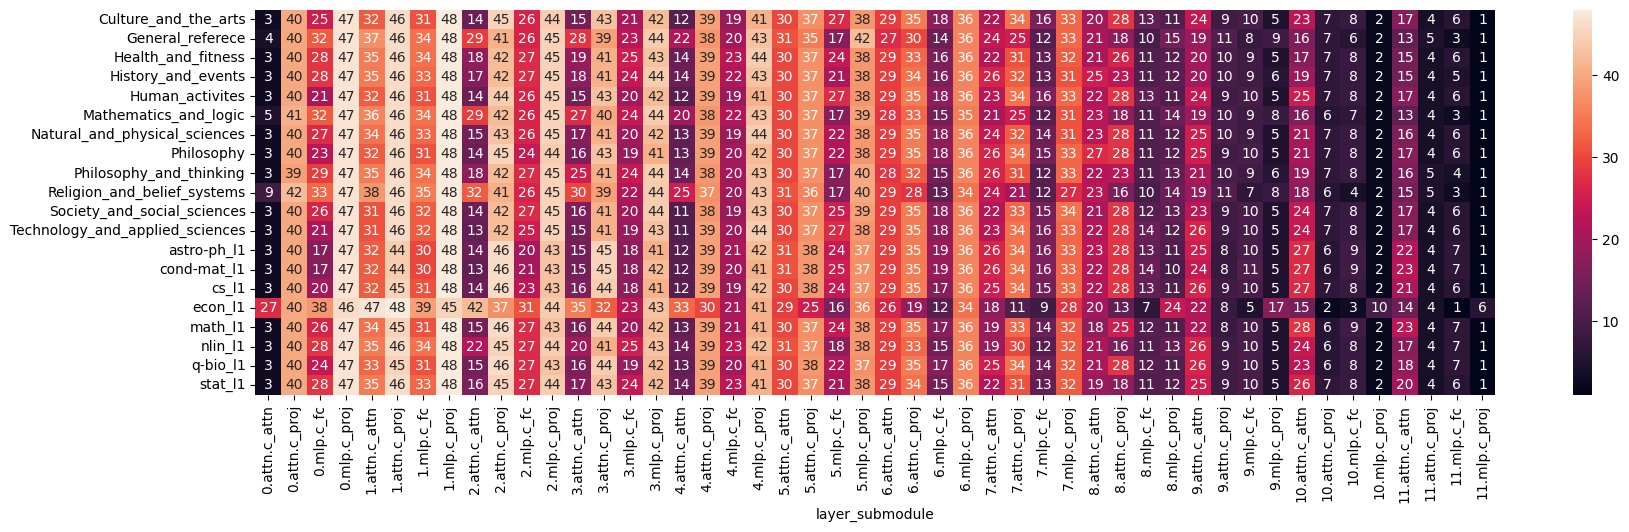

In [ ]:

df_temp.columns = [tup[1] for tup in df_temp.columns]

plt.rcParams["figure.figsize"] = (20,5)
sns.heatmap(
    df_temp.T,
    annot=True
)


# Visualisation

### boxplot for the scaled and mean weight- and bias-differences by layers


<Axes: xlabel='layer', ylabel='scaled_diff'>

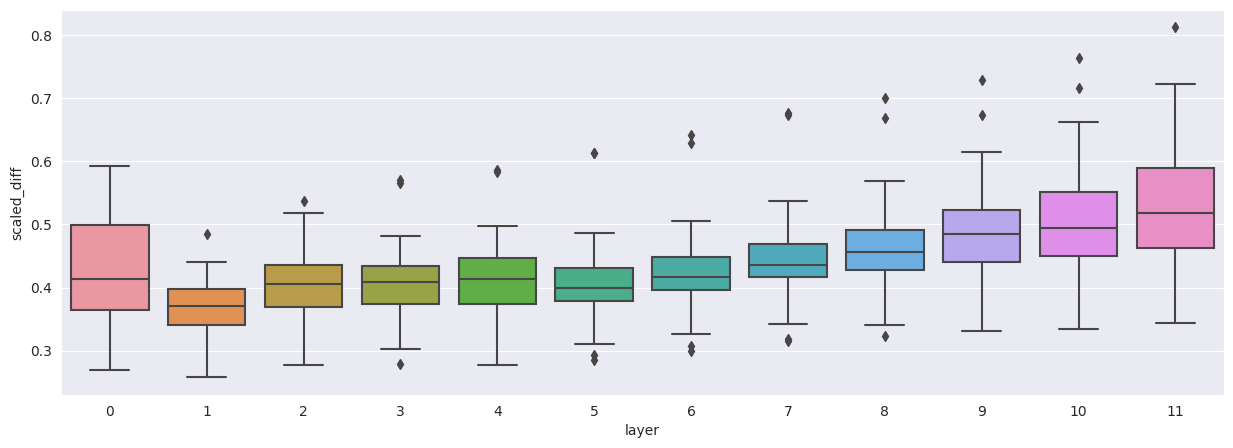

In [91]:
plt.rcParams["figure.figsize"] = (15,5)
# df_avg_diff_weights.layer += 1
sns.boxplot(
#     df_avg_diff_weights,
    df_avg_diff_weights[df_avg_diff_weights.is_localised],
    x='layer',  y='scaled_diff'
#     , errorbar='se'
)
# df_avg_diff_weights.layer -= 1
# df_avg_diff_weights = df_avg_diff_weights.rename({"scaled difference": "diff_v2"}, axis=1)

<Axes: xlabel='layer', ylabel='scaled_diff'>

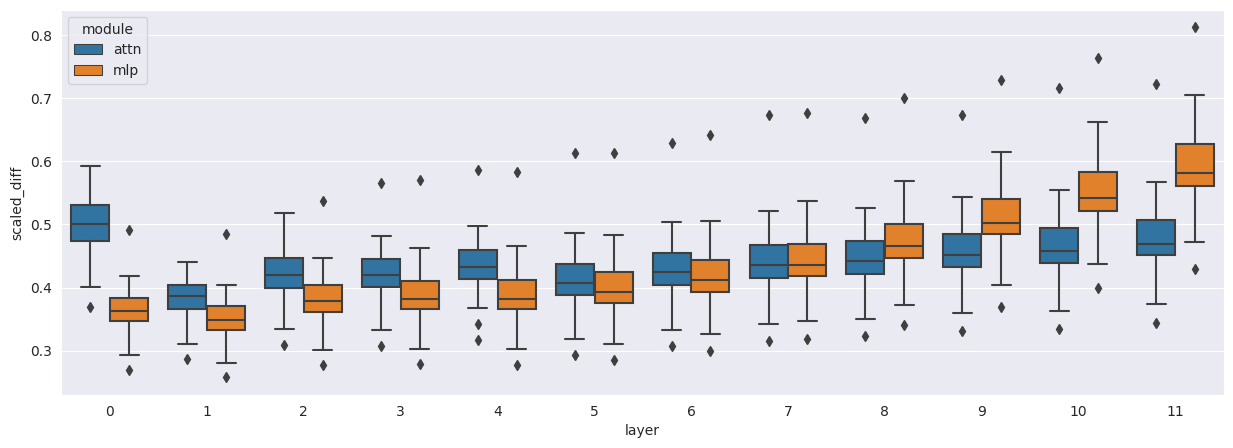

In [46]:
plt.rcParams["figure.figsize"] = (15,5)
# df_avg_diff_weights.layer += 1
sns.boxplot(
#     df_avg_diff_weights,
    df_avg_diff_weights[df_avg_diff_weights.is_localised],
    x='layer',  y='scaled_diff', hue='module'
#     , errorbar='se'
)
# df_avg_diff_weights.layer -= 1
# df_avg_diff_weights = df_avg_diff_weights.rename({"scaled difference": "diff_v2"}, axis=1)